In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pickle

In [7]:
X = sns.load_dataset('iris')
y = X.pop('species')

y = pd.get_dummies(y)

# save label information file
labels = y.columns
labels = {i : label for i, label in enumerate(labels)}
with open('label_info.pickle', 'wb') as f :
    pickle.dump(labels, f)

# read label information file
with open('label_info.pickle', 'rb') as f :
    labels = pickle.load(f)

X = X.to_numpy() # float64
y = y.to_numpy() # uint8


X.shape, y.shape, labels

((150, 4), (150, 3), {0: 'setosa', 1: 'versicolor', 2: 'virginica'})

In [8]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                   random_state = 42,
                                                   test_size = 0.3)

[d.shape for d in [X_train, X_test, y_train, y_test]]

[(105, 4), (45, 4), (105, 3), (45, 3)]

In [9]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# save scaler file
with open('standard_scaler.pickle', 'wb') as f :
    pickle.dump(scaler, f)

# read scaler file
with open('standard_scaler.pickle', 'rb') as f :
    scaler = pickle.load(f)
    
# test
scaler.transform(X_test[0].reshape(1, -1))

array([[ 0.3100623 , -0.50256349,  0.484213  , -0.05282593]])

In [10]:
from tensorflow.keras import models, layers

inputs = layers.Input(shape = (X_train_scaled.shape[1],))

x = layers.Dense(8, activation = 'relu')(inputs)
x = layers.Dense(16, activation = 'relu')(x)
outputs = layers.Dense(y_train.shape[1], activation = 'softmax')(x)

model = models.Model(inputs, outputs)


model.compile(loss = 'categorical_crossentropy',
             optimizer = 'adam',
             metrics = ['accuracy'])

model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 4)]               0         
_________________________________________________________________
dense (Dense)                (None, 8)                 40        
_________________________________________________________________
dense_1 (Dense)              (None, 16)                144       
_________________________________________________________________
dense_2 (Dense)              (None, 3)                 51        
Total params: 235
Trainable params: 235
Non-trainable params: 0
_________________________________________________________________


In [11]:
hist = model.fit(X_train_scaled, y_train,
                epochs = 50,
                batch_size = 8,
                validation_data = (X_test_scaled, y_test))

Epoch 1/50
14/14 [==============================] - 1s 45ms/step - loss: 1.1431 - accuracy: 0.2288 - val_loss: 1.0486 - val_accuracy: 0.3556
Epoch 2/50
14/14 [==============================] - 0s 4ms/step - loss: 1.0861 - accuracy: 0.3607 - val_loss: 0.9928 - val_accuracy: 0.5111
Epoch 3/50
14/14 [==============================] - 0s 3ms/step - loss: 1.0444 - accuracy: 0.4748 - val_loss: 0.9425 - val_accuracy: 0.6444
Epoch 4/50
14/14 [==============================] - 0s 3ms/step - loss: 0.9748 - accuracy: 0.5799 - val_loss: 0.8950 - val_accuracy: 0.6889
Epoch 5/50
14/14 [==============================] - 0s 3ms/step - loss: 0.9493 - accuracy: 0.7063 - val_loss: 0.8497 - val_accuracy: 0.7778
Epoch 6/50
14/14 [==============================] - 0s 3ms/step - loss: 0.9055 - accuracy: 0.7216 - val_loss: 0.7994 - val_accuracy: 0.8667
Epoch 7/50
14/14 [==============================] - 0s 3ms/step - loss: 0.8416 - accuracy: 0.8528 - val_loss: 0.7524 - val_accuracy: 0.8444
Epoch 8/50
14/14 [=

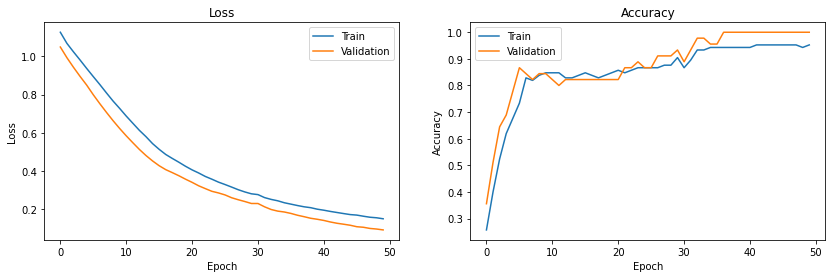

In [12]:
plt.figure(figsize = (14, 4))

plt.subplot(1, 2, 1)
plt.plot(hist.epoch, hist.history['loss'], label = 'Train')
plt.plot(hist.epoch, hist.history['val_loss'], label = 'Validation')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(hist.epoch, hist.history['accuracy'], label = 'Train')
plt.plot(hist.epoch, hist.history['val_accuracy'], label = 'Validation')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [13]:
model.save('iris_model.h5')

In [14]:
new_data = X_test[0]
new_data

array([6.1, 2.8, 4.7, 1.2])

In [15]:
with open('standard_scaler.pickle', 'rb') as f :
    scaler = pickle.load(f)

new_data = scaler.transform(new_data.reshape(1, -1))
new_data

array([[ 0.3100623 , -0.50256349,  0.484213  , -0.05282593]])

In [16]:
pred_prob = model.predict(new_data)[0]
pred_class = pred_prob.argmax()

pred_prob, pred_class

(array([0.00624635, 0.86175835, 0.13199532], dtype=float32), 1)

In [19]:
with open('label_info.pickle', 'rb') as f :
    labels = pickle.load(f)
    
pred_prob = pd.DataFrame(pred_prob, columns = ['prob']).rename(index = labels)
pred_prob = pred_prob.reset_index().sort_values('prob', ascending = False)
pred_prob

,index,prob
2,versicolor,0.861758
1,virginica,0.131995
0,setosa,0.006246


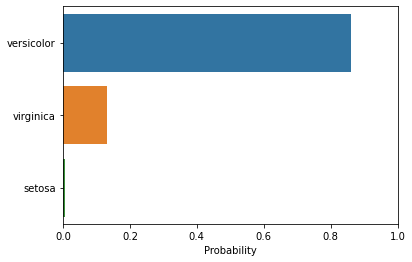

In [20]:
sns.barplot(data = pred_prob, x = 'prob', y = 'index')

plt.xlabel('Probability')
plt.ylabel('')

plt.xlim(0, 1)

plt.show()